In [1]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
# defining the files directory and testing directory
files_dir = 'DATASETFINAL/train'
test_dir = 'DATASETFINAL/test'

# we create a Dataset class which has a __getitem__ function and a __len__ function
class PotholeImagesDataset(torch.utils.data.Dataset):

  def __init__(self, files_dir, width, height, transforms=None):
    self.transforms = transforms
    self.files_dir = files_dir
    self.height = height
    self.width = width
    
    # sorting the images for consistency
    # To get images, the extension of the filename is checked to be jpg
    self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-4:]=='.jpg']
    
    # classes: 0 index is reserved for background
    self.classes = [_, 'pothole']

  def __getitem__(self, idx):
    img_name = self.imgs[idx]
    image_path = os.path.join(self.files_dir, img_name)

    # reading the images and converting them to correct size and color    
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
    # diving by 255
    img_res /= 255.0
    
    # annotation file
    annot_filename = img_name[:-4] + '.txt'
    annot_file_path = os.path.join(self.files_dir, annot_filename)
    
    boxes = []
    labels = []
    
    # cv2 image gives size as height x width
    wt = img.shape[1]
    ht = img.shape[0]
    
    # box coordinates for xml files are extracted and corrected for image size given
    with open(annot_file_path) as f:
      for line in f:
        labels.append(1)
        
        parsed = [float(x) for x in line.split(' ')]
        x_center = parsed[1]
        y_center = parsed[2]
        box_wt = parsed[3]
        box_ht = parsed[4]

        xmin = x_center - box_wt/2
        xmax = x_center + box_wt/2
        ymin = y_center - box_ht/2
        ymax = y_center + box_ht/2
        
        xmin_corr = int(xmin*self.width)
        xmax_corr = int(xmax*self.width)
        ymin_corr = int(ymin*self.height)
        ymax_corr = int(ymax*self.height)
        
        boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
    
    # convert boxes into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    
    # getting the areas of the boxes
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    # suppose all instances are not crowd
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["area"] = area
    target["iscrowd"] = iscrowd
    image_id = torch.tensor([idx])
    target["image_id"] = image_id

    if self.transforms:
      sample = self.transforms(image = img_res,
                                bboxes = target['boxes'],
                                labels = labels)
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])
        
    return img_res, target

  def __len__(self):
    return len(self.imgs)


# check dataset
dataset = PotholeImagesDataset(files_dir, 224, 224)
print('Length of dataset:', len(dataset))

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[70]
print('Image shape:', img.shape)
print('Label example:', target)

Length of dataset: 465
Image shape: (224, 224, 3)
Label example: {'boxes': tensor([[ 80.,  86., 145., 127.]]), 'labels': tensor([1]), 'area': tensor([2665.]), 'iscrowd': tensor([0]), 'image_id': tensor([70])}


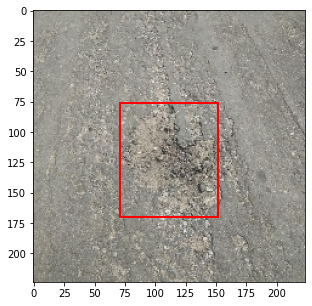

In [3]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  a.imshow(img)
  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)
  plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[2]
plot_img_bbox(img, target)

In [4]:
# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
  if train:
    return A.Compose(
      [
        A.HorizontalFlip(0.5),
        # ToTensorV2 converts image to pytorch tensor without div by 255
        ToTensorV2(p=1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return A.Compose(
      [ToTensorV2(p=1.0)],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

In [5]:
# use our dataset and defined transformations
dataset =PotholeImagesDataset(files_dir, 480, 480, transforms=get_transform(train=True))
dataset_test = PotholeImagesDataset(files_dir, 480, 480, transforms=get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=5,
  shuffle=True,
  num_workers=4,
  collate_fn=utils.collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test,
  batch_size=5,
  shuffle=False,
  num_workers=4,
  collate_fn=utils.collate_fn,
)

In [6]:
def get_object_detection_model(num_classes):
  # load a model pre-trained pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
  return model

In [7]:
# train on gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2 # one class (class 0) is dedicated to the "background"

# get the model using our helper function
model = get_object_detection_model(num_classes)
#
torch.cuda.empty_cache()
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

In [17]:
# training for 5 epochs
num_epochs = 15

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/75]  eta: 0:04:12  lr: 0.000073  loss: 0.0532 (0.0532)  loss_classifier: 0.0188 (0.0188)  loss_box_reg: 0.0335 (0.0335)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 3.3691  data: 0.2663  max mem: 6348
Epoch: [0]  [10/75]  eta: 0:00:55  lr: 0.000748  loss: 0.0774 (0.0769)  loss_classifier: 0.0273 (0.0268)  loss_box_reg: 0.0464 (0.0473)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0013 (0.0020)  time: 0.8536  data: 0.0367  max mem: 6348
Epoch: [0]  [20/75]  eta: 0:00:52  lr: 0.001422  loss: 0.0613 (0.0734)  loss_classifier: 0.0234 (0.0261)  loss_box_reg: 0.0357 (0.0447)  loss_objectness: 0.0007 (0.0008)  loss_rpn_box_reg: 0.0013 (0.0018)  time: 0.8377  data: 0.0140  max mem: 6348
Epoch: [0]  [30/75]  eta: 0:00:36  lr: 0.002097  loss: 0.0613 (0.0782)  loss_classifier: 0.0220 (0.0271)  loss_box_reg: 0.0357 (0.0478)  loss_objectness: 0.0006 (0.0008)  loss_rpn_box_reg: 0.0013 (0.0025)  time: 0.7849  data: 0.0141  max mem: 6348
Epoch: [

In [25]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
  # torchvision returns the indices of the bboxes to keep
  keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
  
  final_prediction = orig_prediction
  final_prediction['boxes'] = final_prediction['boxes'][keep]
  final_prediction['scores'] = final_prediction['scores'][keep]
  final_prediction['labels'] = final_prediction['labels'][keep]
  
  return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
  return torchtrans.ToPILImage()(img).convert('RGB')

In [48]:
test_dir = 'DATASETFINAL/valid'

MODEL OUTPUT



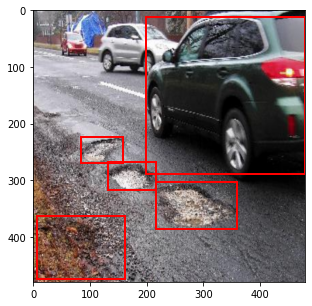

In [70]:
test_dataset = PotholeImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))

# pick one image from the test set
img, target = test_dataset[128]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])[0]
    
print('MODEL OUTPUT\n')
prediction = {key: val.cpu() for key, val in prediction.items()}
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)